In [114]:
include("../z2_ri_poly.jl")
include("../cliff7.jl")
using PyPlot
using Statistics
using LinearAlgebra
using Random
using Profile

In [87]:
function visualize(a::Z2_rip, n)
    d = degree(a)
    p = ri_completion(a.poly)
    tmp = zeros(Bool, 2n+1)
    for i in 1:length(p)
        tmp[mod(n+1-d+i-1, 2n+1)+1] ⊻= p[i]
    end
    # tmp[n+1-d:n+1+d] = p
    return tmp
end


function visualize(a::Array{Z2_rip, 1}, n)
    @assert size(a)==(2,)
    p1 = visualize(a[1])
    p2 = visualize(a[2])
    tmp = zeros(Bool, 2(2n+1))
    tmp[1:2:end] = p1
    tmp[2:2:end] = p2
    return tmp
end


function cqca_to_cliff(cqca, n)
    xz = cqca_tobmat(cqca, n)
    s = fill(0, 2n)
    for k in 1:2n
        h = is_herm(0, view(xz, k, :))
        s[k] = m4(2 * rand(Bool) + !h)
    end
    return Clifford(xz, s)
end


function upper_lower_S(state)
    n = div(size(state, 2), 4)
    m = size(state, 1)
    @assert m == 2n
    upper_cut = div(n, 2)
    mat = zeros(Bool, 2n, 4n)
    mat[:, 1:2upper_cut] = state[1:m, 1:2upper_cut]
    mat[:, 2upper_cut+1:2upper_cut+2n] = state[1:m, 2n+1:2n+2n]
    mat[:, 2upper_cut+2n+1:4n] = state[1:m, 2upper_cut+1:2n]
    rks = binary_all_vertical_cut_ranks!(mat)
    return rks[2upper_cut+2:2:2upper_cut+2n] - (upper_cut+1:upper_cut+n)
end


function op_history_sim(cqca, n_step, n, step_size=1)
    x_mat = zeros(Bool, n_step, 2n+1)
    z_mat = zeros(Bool, n_step, 2n+1)
    tmp = [one(Z2_rip) zero(Z2_rip); zero(Z2_rip) one(Z2_rip)]
    for t in 1:n_step
        x_mat[t, :] = visualize(tmp[1, 1], n)
        z_mat[t, :] = visualize(tmp[1, 2], n)
        tmp = tmp * cqca
    end
    return x_mat, z_mat
end


function ee_sim(cqca, n_step, n, step_size=1)
    result = zeros(Int, n_step, n+1)
    tmp = [one(Z2_rip) zero(Z2_rip); zero(Z2_rip) one(Z2_rip)]
    for t in 1:n_step
        mat = cqca_to_bmat(tmp, n)
        result[t, :] = left_ee_on_all_cuts(mat[1:2:end, :])
        for _ in 1:step_size
            tmp = tmp * cqca
        end
    end
    return result
end


function upper_lower_S_sim(cqca, n_step, n, step_size=1)
    result = zeros(Int, n_step, div(n, 2))
    tmp = [one(Z2_rip) zero(Z2_rip); zero(Z2_rip) one(Z2_rip)]
    for t in 1:n_step
        mat = cat(cqca_to_bmat(tmp, n), Matrix(true*I, 2n, 2n), dims=2)
        result[t, :] = upper_lower_S(mat)[div(n,2)+1:n]
        for _ in 1:step_size
            tmp = tmp * cqca
        end
    end
    return result
end


function tmi_sim(r, cqca, n_step, n, step_size=1)
    result = zeros(Int, n_step, 3)
    tmp = [one(Z2_rip) zero(Z2_rip); zero(Z2_rip) one(Z2_rip)]

    A = 1:Int(r*n)
    B = n+div(n,2)+1:n+div(n,2)+Int(r*n)
    C = setdiff(n+1:2n, B)

    for t in 1:n_step
        mat = cat(cqca_to_bmat(tmp, n), Matrix(true*I, 2n, 2n), dims=2)
        
        result[t, :] = [mutual_info(mat, A, B), mutual_info(mat, A, C), mutual_info(mat, A, union(B, C))]
        for _ in 1:step_size
            tmp = tmp * cqca
        end
    end
    return result
end

tmi_sim (generic function with 3 methods)

In [32]:
Random.seed!(2)

n_step = 64
n = 128
r = 1/8


cqcas = get_all_cqca(2)
# n_cqcas = 5
n_cqcas = length(cqcas)

mxzs = []
ees = []
tmis = []

for i in 1:n_cqcas
    cqca = cqcas[i]

    mx, mz = op_history_sim(cqca, n_step, n)
    push!(mxzs, cat(mx[:, n+1:2n],mz[:, n+1:2n], dims=1))

    ee = ee_sim(cqca, n_step, n)#[:, div(n, 2)+1:end]
    push!(ees, ee)

    tmi = tmi_sim(r, cqca, 2n_step, n)
    push!(tmis, tmi)

    # ul_s = upper_lower_S_sim(cqca, n_step, n)#[:, div(n, 2)+1:end]
end

In [95]:
n_cqcas

44

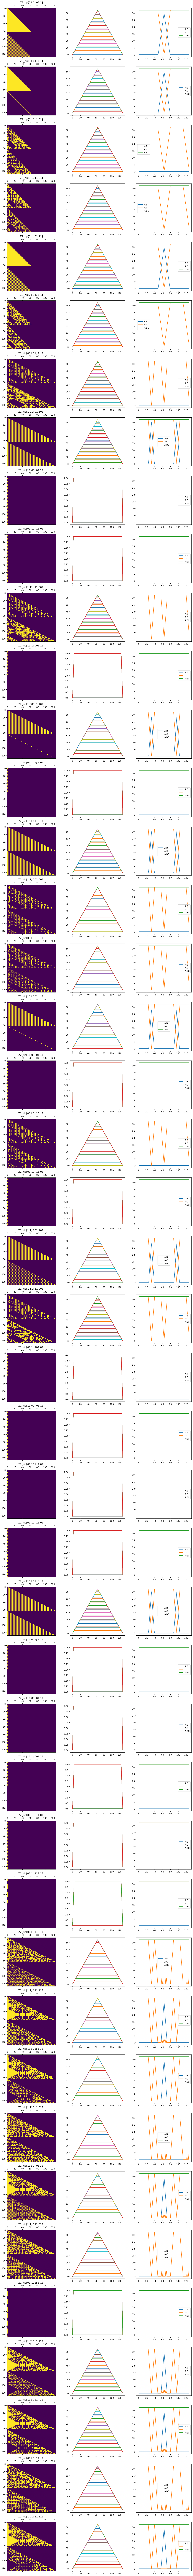

In [94]:
fg, ax = subplots(n_cqcas, 3, figsize=(16,5*n_cqcas))
for i in 1:n_cqcas

    ax[i, 1].matshow(mxzs[i])

    ax[i, 2].plot(ees[i]')

    ax[i, 3].plot(tmis[i][:, 1], label="A:B")
    ax[i, 3].plot(tmis[i][:, 2], label="A:C")
    ax[i, 3].plot(tmis[i][:, 3], label="A:BC")
    ax[i, 3].legend()

    ax[i, 1].set_title(string(cqcas[i]))
end
fg

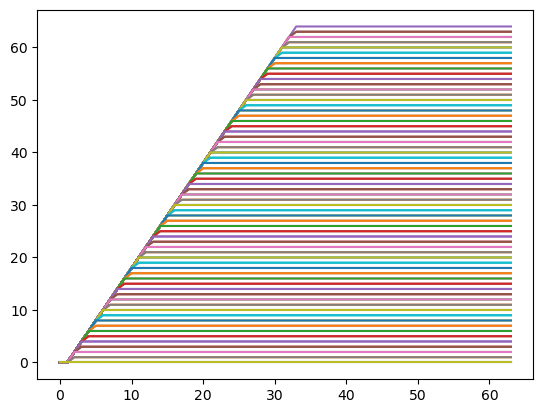

In [64]:
fg, ax = subplots(1,1)
ax.plot(ees[3])
fg

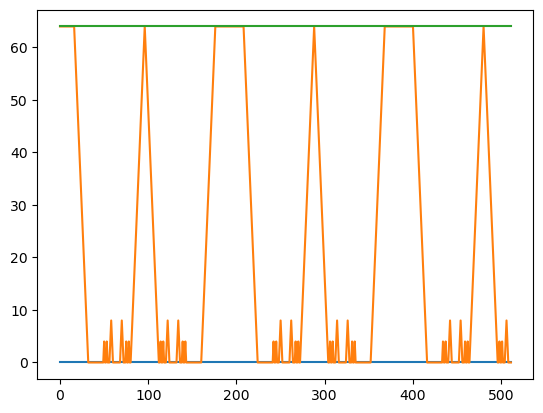

In [69]:
fg,ax = subplots(1,1)
a = tmi_sim(1/4, cqcas[34], 512, 128)
ax.plot(a)

fg

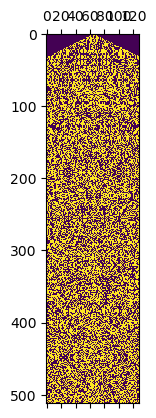

In [91]:
fg,ax = subplots(1,1)
a = op_history_sim(cqcas[39], 512, 64)
ax.matshow(a[1])

fg

In [131]:
function is_id(mat)
    for i in 1:size(mat, 1)
        for j in 1:size(mat, 1)
            if (i==j) && mat[i, j]==false
                return false
            end
            if (i!=j) && mat[i, j]==true
                return false
            end
        end
    end
    return true
end


n = 32
mat = cqca_to_bmat(cqcas[39], n)
tmp = Matrix(true * I, 2n, 2n)


for i in 1:2048
    tmp = isodd.(tmp * mat)
    if is_id(tmp)
        print(i)
        break
    end
end

48

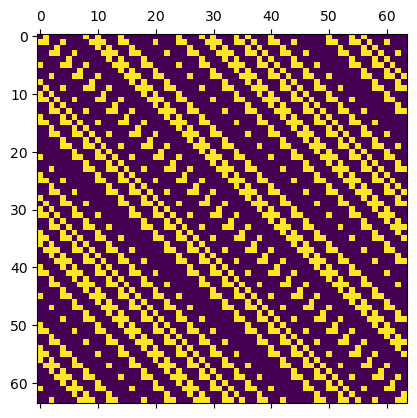

In [140]:
fg,ax = subplots(1,1)
ax.matshow(isodd.(mat^32))
fg


In [142]:
a = cqca_to_bmat(cqcas[39]^32, 32)
b = isodd.(cqca_to_bmat(cqcas[39], 32)^32)

64×64 BitArray{2}:
 0  1  0  0  0  0  0  0  1  0  1  0  0  …  0  0  1  0  1  0  0  0  0  0  0  0
 1  1  0  0  1  0  0  0  0  1  1  1  0     0  0  1  1  0  1  0  0  1  0  0  0
 0  0  0  1  0  0  0  0  0  0  1  0  1     1  0  0  0  1  0  1  0  0  0  0  0
 0  0  1  1  0  0  1  0  0  0  0  1  1     1  1  0  0  1  1  0  1  0  0  1  0
 0  0  0  0  0  1  0  0  0  0  0  0  1     0  0  1  0  0  0  1  0  1  0  0  0
 1  0  0  0  1  1  0  0  1  0  0  0  0  …  0  0  1  1  0  0  1  1  0  1  0  0
 0  0  0  0  0  0  0  1  0  0  0  0  0     0  0  0  0  1  0  0  0  1  0  1  0
 0  0  1  0  0  0  1  1  0  0  1  0  0     0  0  0  0  1  1  0  0  1  1  0  1
 1  0  0  0  0  0  0  0  0  1  0  0  0     0  0  0  0  0  0  1  0  0  0  1  0
 0  1  0  0  1  0  0  0  1  1  0  0  1     1  0  0  0  0  0  1  1  0  0  1  1
 ⋮              ⋮              ⋮        ⋱           ⋮              ⋮        
 1  1  0  0  1  1  0  0  0  0  1  0  0  …  0  0  1  1  0  0  1  0  0  0  0  1
 1  0  1  0  0  0  1  0  0  0  0  0  0     0  

In [164]:
c = cqcas[39]
p = (c^48)[1,1].poly

95-element Array{Bool,1}:
 1
 0
 1
 1
 1
 0
 1
 1
 0
 0
 ⋮
 0
 0
 0
 1
 1
 0
 1
 1
 1

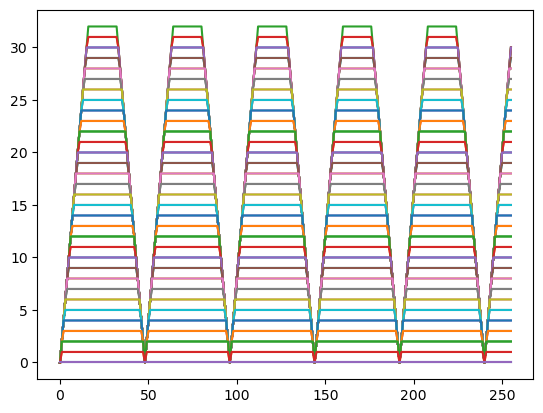

In [162]:
result = ee_sim(cqcas[4], 256, 64)
fg,ax = subplots(1,1)
ax.plot(result)
fg

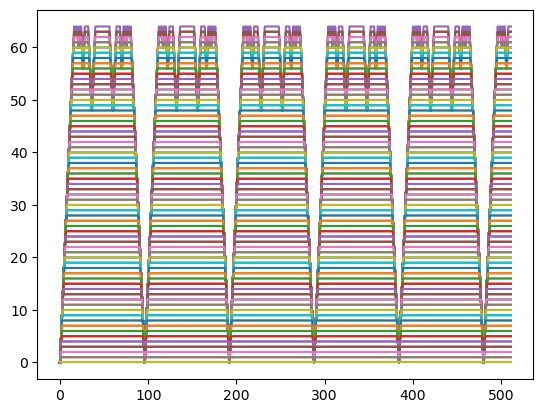

In [166]:
pp = ri_completion(p)

189-element Array{Bool,1}:
 1
 1
 1
 0
 1
 1
 0
 0
 0
 0
 ⋮
 0
 0
 0
 1
 1
 0
 1
 1
 1

In [183]:
pp = ri_completion((cqcas[39]^48)[2,1].poly)
u = zeros(Int, 32)
for i in 1:32:length(pp)
    q = pp[i:min(i+31, length(pp))]
    u[1:length(q)] += q 
end  
sum(isodd.(u))

0

85